In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, CuDNNGRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import pandas as pd
import numpy as np
import string, os 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/combined.txt') as f:
    line = f.readlines()

len(line)

8439

In [ ]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.strip('\n')
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in line]
corpus[:10]

['they call me mr carter i kissed the daughter',
 'of the deads forehead i killed the father',
 'spilled the heart of a mildew hater',
 'i will put them body on chill like glaciers',
 'gracias im crazy yes its obvious',
 'going against me is atheist',
 'i got my angels on my shoulders and a quarter of that angel dust',
 'i aint sniffin im just pitchin ya honor i aint snitchin ya honor',
 'hate bitch nixgas bitches with power',
 'vacate when the kitchen get hotter']

**Tokenization**

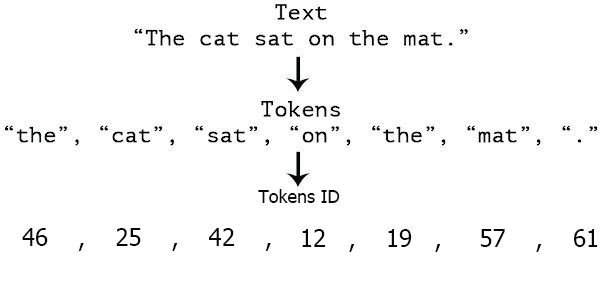

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

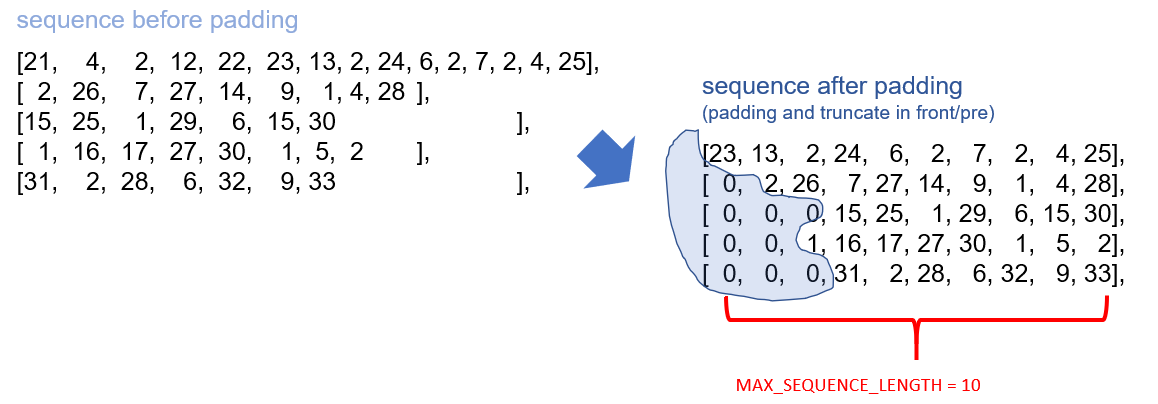

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
model = Sequential()

# Add Input Embedding Layer
model.add(Embedding(total_words, 10, input_length=max_sequence_len - 1))

# Add Hidden Layer 1 - GRU Layer
model.add(CuDNNGRU(10))

# Add Output Layer
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 65, 10)            68220     
                                                                 
 cu_dnngru (CuDNNGRU)        (None, 10)                660       
                                                                 
 dense (Dense)               (None, 6822)              75042     
                                                                 
Total params: 143,922
Trainable params: 143,922
Non-trainable params: 0
_________________________________________________________________


Lets train our model now

In [ ]:
model.fit(predictors, label, epochs=100)

Epoch 1/100
1928/1928 [==============================] - 28s 13ms/step - loss: 6.8331
Epoch 2/100
1928/1928 [==============================] - 27s 14ms/step - loss: 6.4177
Epoch 3/100
1928/1928 [==============================] - 28s 14ms/step - loss: 6.2917
Epoch 4/100
1928/1928 [==============================] - 27s 14ms/step - loss: 6.1770
Epoch 5/100
1928/1928 [==============================] - 27s 14ms/step - loss: 6.0665
Epoch 6/100
1928/1928 [==============================] - 27s 14ms/step - loss: 5.9527
Epoch 7/100
1928/1928 [==============================] - 27s 14ms/step - loss: 5.8564
Epoch 8/100
1928/1928 [==============================] - 27s 14ms/step - loss: 5.7778
Epoch 9/100
1928/1928 [==============================] - 27s 14ms/step - loss: 5.7078
Epoch 10/100
1928/1928 [==============================] - 27s 14ms/step - loss: 5.6419
Epoch 11/100
1928/1928 [==============================] - 27s 14ms/step - loss: 5.5796
Epoch 12/100
1928/1928 [============================

In [ ]:
def text_generate(seed_text):
    for _ in range(5):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
print(text_generate("money"))
print(text_generate("like"))
print(text_generate("key"))
print(text_generate("Buildin"))
print(text_generate("Pills"))
print(text_generate("Be Wit"))

Money In The Air If You
Like I Got The Game And
Key On You Want To Get
Buildin You Want Nixga I Got
Pills Am I Got The Limit
Be Wit The Money In The House
